# Static Bayesian Optimization: 
- initial training on burnin points
- use acquisition function to guide next sampling
- re-optimize the model
- plot and visualize before and after
- loop and use acquistion function for up to 100 samples. 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [3]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1_X0, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, ker_BaO, 
                               slice_dim, ylabel, initialize_data_dr_sim):
        # TODO: clean up and fix this function
        sampling_freq = np.empty((n_samples))
        sampling_freq[:] = 35
        sampling_amp = np.empty((n_samples))
        sampling_amp[:] = 40

        testX_BaO = np.array([sampling_freq, sampling_amp])
        testX = np.transpose(testX_BaO)
        
        state_est_BaO = np.empty((n_samples,1))
        simY_BaO = np.empty((n_samples, 1))
        simMse_BaO = np.empty((n_samples, 1))

        for i in range(n_samples-1):
            state_est_BaO[i:i+2, 0], simY_BaO[i:i+2,0:1], simMse_BaO[i:i+2,0:1] = self.sample(testX_BaO, trained_model_BaO);

        print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])
        
        nu = 0.1
        print("nu set at: ", nu)
        ucb = np.empty((1))
        freq_choices = [5,7,11,17, 23, 35, 42]

        ucb= self.acquisition_function(simY_BaO, simMse_BaO, nu, 1)
        median_ucb = np.median(ucb)
        next_freq_idx = abs(median_ucb-freq_choices).argmin()
          
        for idx in range(n_samples, np.shape(U1)[0]):
            if U1.loc[idx,'Stim_1']==freq_choices[next_freq_idx]:
                # print(idx)
                next_idx_to_optimize.append(idx)
                if np.size(next_idx_to_optimize)>n_samples:
                    break
        
        U1_next = U1.loc[next_idx_to_optimize,:]
        X0_psd_next = X0_psd.loc[next_idx_to_optimize]
        X1_next = X1[next_idx_to_optimize,:]
        
        U1_combo = pd.concat([U1_init,U1_next])
        X0_psd_combo = pd.concat([X0_psd_init, X0_psd_next])
        X1_combo = np.append(X1_init, X1_next, axis=0)
        
        U1_combo.reset_index()
        U1_combo=U1_combo[['Stim_1', 'Stim_2']]

        X0_psd_combo.reset_index()
        X0_psd_combo= X0_psd_combo[['sum_preStim_gamma']]
        
        x_BaO, y_BaO, trained_model_BaO = self.initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)
        
        return x_BaO, y_BaO, trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [4]:
model = state_dr_gp()

In [10]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [11]:
print('Sum preStim gamma are: \n', X0_psd, '\n','freq and amplitude used are: \n', U1[0:4])

Sum preStim gamma are: 
      sum_preStim_gamma
0             3.266571
1             2.425945
2             3.117866
3             2.868627
4             3.521665
..                 ...
379           1.268502
380           1.239859
381           1.880050
382           1.199899
383           1.343332

[384 rows x 1 columns] 
 freq and amplitude used are: 
    Stim_1  Stim_2
0      17      30
1      42      40
2      35      30
3      23      50


In [12]:
U1.loc[0:10, 'Stim_1']

0     17
1     42
2     35
3     23
4     42
5     35
6     11
7      7
8     17
9     11
10    17
Name: Stim_1, dtype: int64

In [13]:
print(np.shape(U1), np.shape(X0_psd))

(384, 2) (384, 1)


In [14]:
n_burn_in = 20
n_samples= 150
n_acquisition = 50

## 1.2 First BaO Model is trained on all of the dataset

In [15]:
ker_BaO = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [16]:
slice_dim = 1
ylabel='Predicted Gamma'

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1c5fd30b4c0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1c5fd30b8e0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   3.584623e+03           nan 
    01s26  0014   1.125273e+03   6.182111e-01 
    02s27  0023   1.115940e+03   1.949074e-01 
    03s36  0034   1.115247e+03   6.434336e-10 
Runtime:     03s36
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1c580de1a90>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1c5800bea00>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1c581193370>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1c581193790>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1c5811937c0>]}

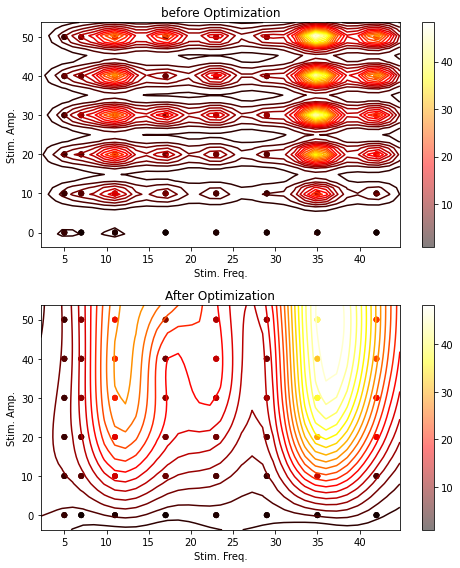

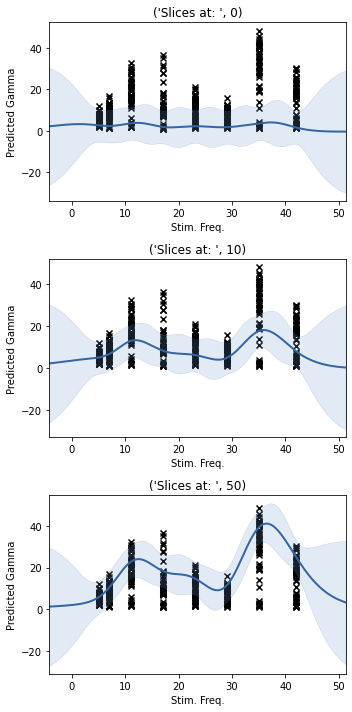

In [17]:
x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, X0_psd, X1, ker_BaO, slice_dim, ylabel)

## 1.3: Train the second model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp/PreStimGamma 

- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [18]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1.loc[0:n_burn_in-1,:]
X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1[0:n_burn_in,:]
print('Sum preStim gamma are: \n', X0_psd_init, '\n','freq and amplitude used are: \n', U1_init)
print('sum postStim gamma are: \n', X1_init)

Sum preStim gamma are: 
     sum_preStim_gamma
0            3.266571
1            2.425945
2            3.117866
3            2.868627
4            3.521665
5            1.384478
6            1.420178
7            1.533292
8            2.019014
9            2.231953
10           2.347957
11           2.131811
12           1.934441
13           2.512154
14           4.690816
15           2.645199
16           6.401632
17           1.984354
18           3.580944
19           2.032816 
 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010

In [19]:
# input_data
U1_X0_init = U1_init.join(X0_psd_init)

#### initial training

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1c5805a8f40>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1c580590d90>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0004   7.051366e+01   7.256383e-03 
    00s17  0014   6.999564e+01   2.688284e-03 
    00s19  0017   6.973546e+01   3.728068e-02 
    00s33  0030   6.946105e+01   5.485899e-12 
Runtime:     00s33
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1c5800ebfa0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1c5800d48e0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1c58035ec40>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1c5803a0910>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1c5803a0940>]}

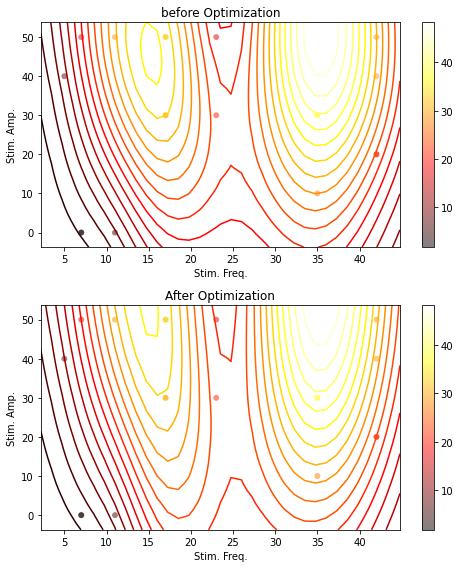

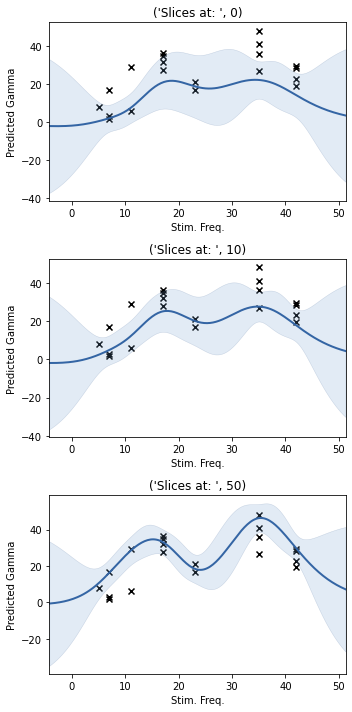

In [20]:
x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO, slice_dim, ylabel)

#### use the acquisition function to guide the next freq to optimize at

In [22]:
rand_freq_1d = np.random.choice(np.arange(1,43,1), size=(n_samples))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted)
rand_amp_1d = np.random.choice(np.arange(1,51,1), size=(n_samples))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))

[ 1  1  1  2  2  2  3  3  3  3  4  4  4  5  5  5  6  6  6  6  6  7  7  7
  8  8  8  8  8  8  8  9  9  9  9 10 10 11 11 11 11 12 12 12 13 13 13 13
 14 14 15 15 16 16 16 16 17 17 18 18 18 18 18 18 19 19 19 19 20 20 20 20
 20 21 21 21 21 21 22 22 22 23 23 24 24 24 24 25 26 26 26 27 27 27 27 27
 27 27 28 29 29 29 30 30 31 31 32 32 32 32 33 33 33 33 33 33 33 33 33 33
 34 34 34 34 34 34 34 34 35 35 35 35 36 36 37 37 37 38 38 39 39 39 40 40
 41 41 41 42 42 42]
[ 1  1  1  1  1  2  2  3  3  4  4  4  5  5  5  6  7  7  8  9  9  9  9  9
  9  9 10 11 11 11 12 12 12 12 13 13 14 14 14 15 15 15 15 15 15 16 16 17
 17 17 17 18 18 18 18 19 19 20 20 20 20 21 21 22 22 23 23 23 23 24 24 24
 25 25 25 26 26 26 26 26 27 28 29 29 29 29 30 30 31 31 31 31 31 31 33 34
 34 34 35 35 35 37 37 38 38 38 38 38 39 39 39 39 39 40 40 40 40 40 40 42
 42 42 43 43 44 44 44 45 45 45 45 46 46 46 46 46 47 47 48 48 48 49 49 49
 50 50 50 50 50 50] (150,)


In [26]:
# sample mean preStimGamma
mean_preStimGamma = np.empty((n_samples,))
mean_preStimGamma[:] = np.mean(X0_psd, axis=0)
print(mean_preStimGamma[0], np.shape(mean_preStimGamma))

2.171337907722562 (150,)


In [29]:
print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted, mean_preStimGamma])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(testX_BaO[0:3, 0:3])

(150,) (150,)
(3, 150)
[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [2.17133791 2.17133791 2.17133791]]


In [43]:
state_est_BaO = np.empty((3, n_samples))
simY_BaO = np.empty((3, n_samples))
simMse_BaO = np.empty((3, n_samples))

for i in range(n_samples-1):
        # print(i)
    state_est_BaO[:, i], simY_BaO[:, i:i+1], simMse_BaO[:, i:i+1] = model.sample(testX_BaO, trained_model_BaO_AF);

print("mean is: \n",simY_BaO[:,0:3],"\n\n Variance is: \n", simMse_BaO[:,0:3])
# posteriorTestY
print(np.shape(state_est_BaO),'\n',state_est_BaO[:,0:10])
print(np.shape(simY_BaO),'\n', np.shape(simMse_BaO))

mean is: 
 [[-1.52078077 -1.52078077 -1.52078077]
 [-1.52078077 -1.52078077 -1.52078077]
 [-0.94677437 -0.94677437 -0.94677437]] 

 Variance is: 
 [[130.04288146 130.04288146 130.04288146]
 [130.04288146 130.04288146 130.04288146]
 [ 88.45509794  88.45509794  88.45509794]]
(3, 150) 
 [[  3.24706595 -12.21607744  -6.38886845  -5.46731648  -8.90236548
   -8.76753739   3.64005995  -7.44165008 -11.29484268   0.02003836]
 [  2.95541906 -12.22740313  -6.39224108  -5.35846007  -8.8026277
   -8.86903589   3.41993967  -7.37782368 -11.33565835   0.07089169]
 [  0.30275147  -8.29174983  -2.9236112   -4.88318619  -7.886983
   -9.39466807   5.00448165  -4.10647539  -6.79082364   2.28060704]]
(3, 150) 
 (3, 150)


In [44]:
# inspecting the inputs to acquistion_function:
print(np.shape(testX_BaO))
print(testX_BaO[:,0:3])

# Mean and variance after initial training using "burn-in" points:
print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])

nu = 0.1
print("nu set at: ", nu)
# t = the sample we are on 

(3, 150)
[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [2.17133791 2.17133791 2.17133791]]
mean is: 
 -1.5207807709399301 

 Variance is: 
 130.0428814611011
nu set at:  0.1


nu set at:  0.1
mean is: 
 [-1.52078843 -1.52078843] 

 Variance is: 
 [130.0430273 130.0430273]
(2, 150) 
 [[ -0.33077833  -3.17028009  -3.63933384  -4.15543031  17.48338327
  -17.74693224  15.88253886   5.99874273  -5.93507306  13.49593696]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]]
(2, 150) 
 (2, 150)
39.50774763017829
6 next freq is:  42
[163]
Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
sum postStim gamma are: 
 [[17.37915242]] 
 (1, 1)
(21, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ed6ae550>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ed693070>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s08  0008   7.498378e+01   1.187863e-03 
    00s18  0016   7.496387e+01   1.443899e-08 
    00s32  0032   7.496343e+01   5.424068e-10 
Runtime:     00s32
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ed8ea490>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ed8c9be0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9eda76970>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d9eda76eb0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d9eda76850>]}

mean is: 
 [-1.75170875 -1.75170875] 

 Variance is: 
 [147.90928349 147.90928349]
(2, 150) 
 [[ -9.75404154  -9.25332858   1.45572423   3.6825716   15.49691892
   -9.41352663  26.43932682 -23.62503728 -14.96814263 -15.31279593]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]]
(2, 150) 
 (2, 150)
44.91362577176135
6 next freq is:  42
[163]
Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
sum postStim gamma are: 
 [[17.37915242]] 
 (1, 1)
(21, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17       17     

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9edabfa00>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9edaaa9a0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0006   7.496344e+01   9.213301e-07 
    00s12  0009   7.496343e+01   8.250565e-10 
Runtime:     00s12
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9edb79af0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9edb72610>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9edcce130>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d9edcdb520>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d9edcdb550>]}

mean is: 
 [-1.75139566 -1.75139566] 

 Variance is: 
 [147.92009835 147.92009835]
(2, 150) 
 [[-1.12660193  0.47392316  2.99852965 -9.19424249 16.53814105 -9.49333086
  -2.89692553 -6.62289468 -1.4463914  -9.34282236]
 [46.66533452 46.66533452 46.66533452 46.66533452 46.66533452 46.66533452
  46.66533452 46.66533452 46.66533452 46.66533452]]
(2, 150) 
 (2, 150)
44.91735095030321
6 next freq is:  42
[163]
Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
sum postStim gamma are: 
 [[17.37915242]] 
 (1, 1)
(21, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17       17      50
18      

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9edd232e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9edcffca0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0007   7.496343e+01   1.901269e-09 
Runtime:     00s07
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9edddff40>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9eddc6f70>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ed6032b0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d9ed603d90>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d9ed603c40>]}

mean is: 
 [-1.75127098 -1.75127098] 

 Variance is: 
 [147.92400361 147.92400361]
(2, 150) 
 [[ -5.81787614  19.50155735  -0.16652053  -2.9782734   -5.12667328
  -12.79897215  12.7598776   -3.15555835  -1.23693568 -20.30657755]
 [ 46.66874661  46.66874661  46.66874661  46.66874661  46.66874661
   46.66874661  46.66874661  46.66874661  46.66874661  46.66874661]]
(2, 150) 
 (2, 150)
44.918707732312534
6 next freq is:  42
[163]
Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
sum postStim gamma are: 
 [[17.37915242]] 
 (1, 1)
(21, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17     

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ed50a0d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ed5f6e50>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0004   7.496344e+01   7.630644e-07 
    00s22  0011   7.496343e+01   2.504268e-11 
Runtime:     00s22
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ed5874f0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ead0d760>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ed4b56d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d9ed4b5c10>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d9ed4b5c40>]}

mean is: 
 [-1.7516589 -1.7516589] 

 Variance is: 
 [147.9117509 147.9117509]
(2, 150) 
 [[ -0.23520709  12.84619781 -29.26367317 -19.31758169  -1.19296648
    0.66413591  22.29500235  12.97083538  -3.23192592 -17.45774905]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]]
(2, 150) 
 (2, 150)
44.914454090607876
6 next freq is:  42
[163]
Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
sum postStim gamma are: 
 [[17.37915242]] 
 (1, 1)
(21, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17       17      50

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ed3fc6d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ed3eb730>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0002   7.497680e+01   2.256892e-03 
    00s13  0005   7.496343e+01   6.107867e-11 
    00s15  0006   7.496343e+01   6.107867e-11 
Runtime:     00s15
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ed7d1760>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ed7af460>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9edfb2c70>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d9edfc41f0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d9edfb2bb0>]}

mean is: 
 [-1.75164948 -1.75164948] 

 Variance is: 
 [147.91233955 147.91233955]
(2, 150) 
 [[-15.09957434   7.57884576  10.10655654   2.77506832 -14.04402245
   11.88677355  -0.6460572  -15.91116576  -7.33402689  -3.14509488]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]]
(2, 150) 
 (2, 150)
44.914649223128926
6 next freq is:  42
[163]
Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
sum postStim gamma are: 
 [[17.37915242]] 
 (1, 1)
(21, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17       17    

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9edfffdc0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9edfe7c70>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   7.496347e+01           nan 
    00s05  0004   7.496343e+01   1.049956e-06 
    00s11  0006   7.496343e+01   5.814424e-12 
Runtime:     00s11
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ee0c4eb0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ee0af880>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ee2174f0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d9ee217910>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d9ee217940>]}

mean is: 
 [-1.75162248 -1.75162248] 

 Variance is: 
 [147.91287958 147.91287958]
(2, 150) 
 [[-11.75921271  -7.45744868  -5.85178927 -22.56035698  11.37600989
   -2.05251742  -9.11536392   1.75578411   9.38629547  -9.7951887 ]
 [ 46.66533452  46.66533452  46.66533452  46.66533452  46.66533452
   46.66533452  46.66533452  46.66533452  46.66533452  46.66533452]]
(2, 150) 
 (2, 150)
44.91484660692467
6 next freq is:  42
[163]
Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
sum postStim gamma are: 
 [[17.37915242]] 
 (1, 1)
(21, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17      

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ee25f760>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ee247160>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s19  0006   7.496343e+01   5.816163e-12 
Runtime:     00s19
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ee31a460>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ee30e040>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ee46a610>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d9ee46ab50>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d9ee46ab80>]}

mean is: 
 [-1.75162011 -1.75162011] 

 Variance is: 
 [147.91292963 147.91292963]
(2, 150) 
 [[ 1.86478863e+01 -1.50517727e+01  1.99332514e+00 -1.61194597e+01
  -5.79667278e+00 -2.05148553e+01 -4.14612920e-02 -9.59943756e-01
  -6.02724938e+00 -1.02022230e+01]
 [ 4.66664691e+01  4.66664691e+01  4.66664691e+01  4.66664691e+01
   4.66664691e+01  4.66664691e+01  4.66664691e+01  4.66664691e+01
   4.66664691e+01  4.66664691e+01]]
(2, 150) 
 (2, 150)
44.914864768330474
6 next freq is:  42
[163]
Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
sum postStim gamma are: 
 [[17.37915242]] 
 (1, 1)
(21, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ee4b58b0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ee49d400>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0003   7.496343e+01   1.664676e-08 
    00s10  0005   7.496343e+01   7.434632e-09 
Runtime:     00s10
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9eda852e0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9eda85400>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ef67bc40>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d9ef68c1c0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d9ef68c1f0>]}

mean is: 
 [-1.75189092 -1.75189092] 

 Variance is: 
 [147.90469817 147.90469817]
(2, 150) 
 [[ -4.89229964  -2.13949447 -31.83295717  10.66884699  -5.00940032
  -11.02455672 -11.74359362 -26.07644315  -5.40495609  14.89080653]
 [ 44.91484661  44.91484661  44.91484661  44.91484661  44.91484661
   44.91484661  44.91484661  44.91484661  44.91484661  44.91484661]]
(2, 150) 
 (2, 150)
44.91199693720559
6 next freq is:  42
[163]
Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
sum postStim gamma are: 
 [[17.37915242]] 
 (1, 1)
(21, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17      

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ef6c2e80>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ef6a9be0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   7.496343e+01   9.316039e-09 
    00s03  0004   7.496343e+01   2.658067e-10 
Runtime:     00s03
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ef7729a0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1d9ef788fa0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x1d9ef8d9670>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1d9ef8d9bb0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1d9ef8cb4c0>]}

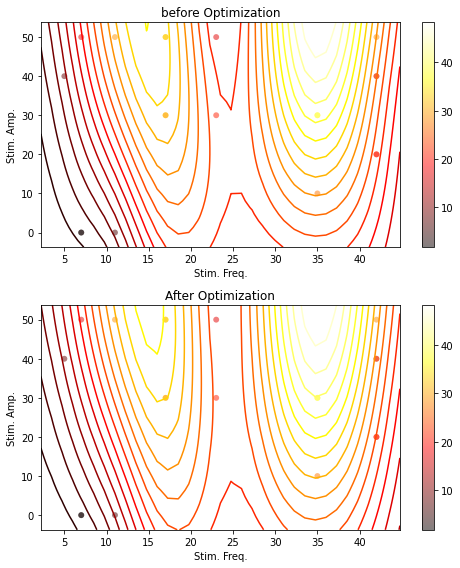

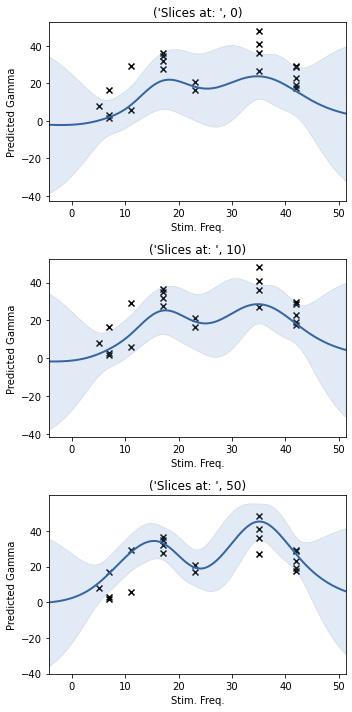

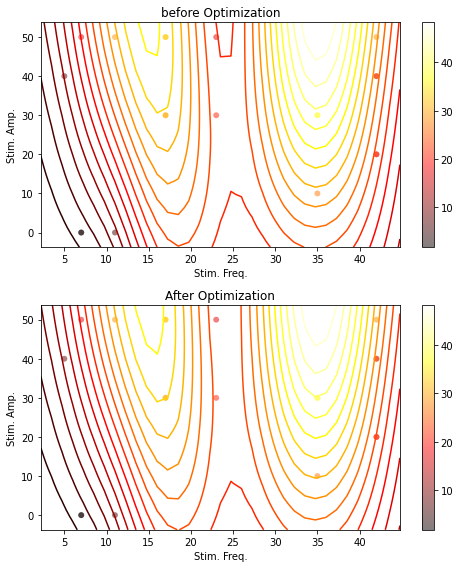

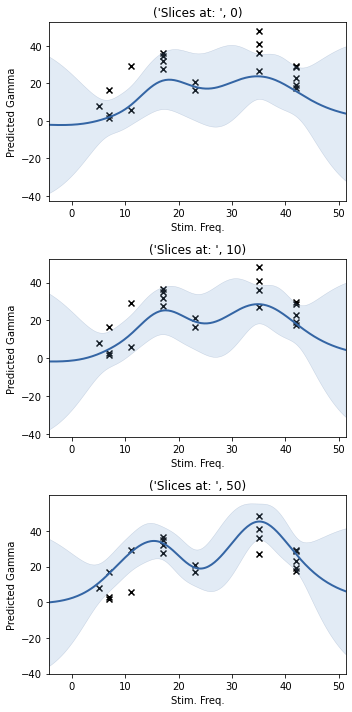

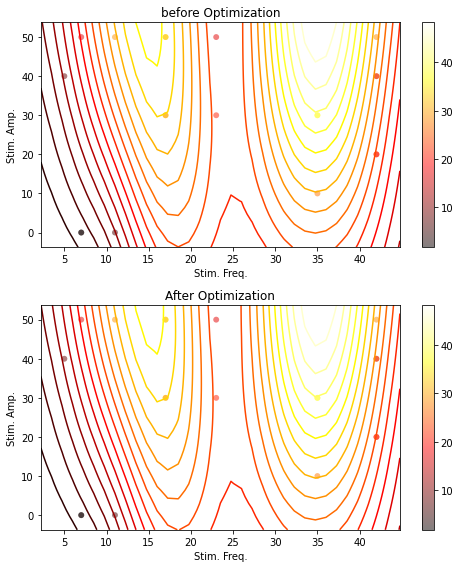

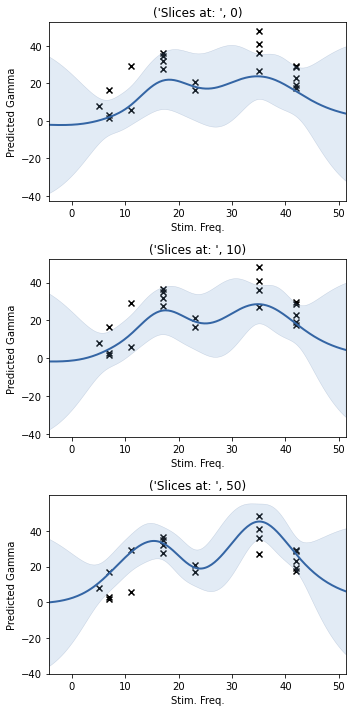

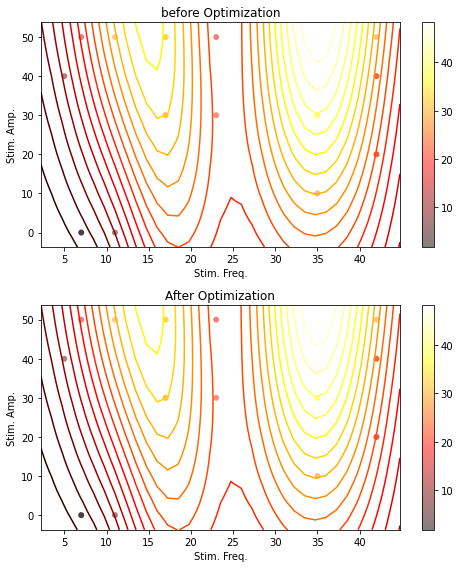

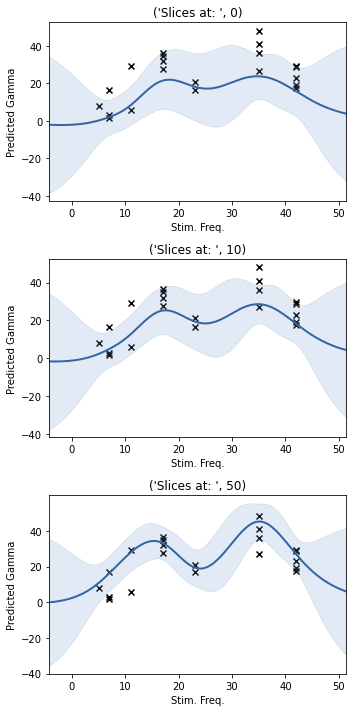

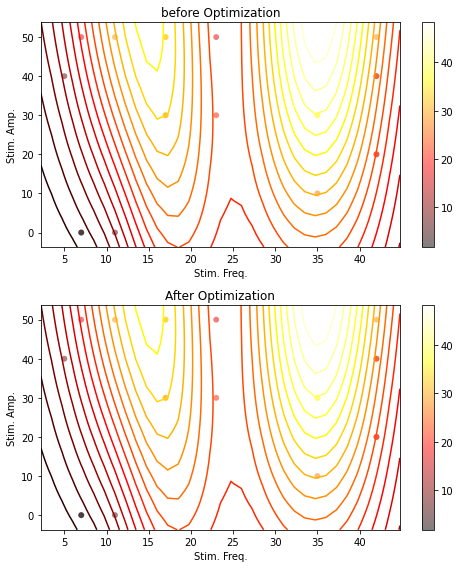

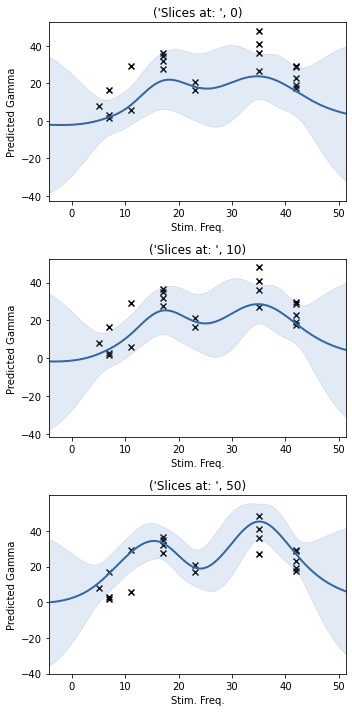

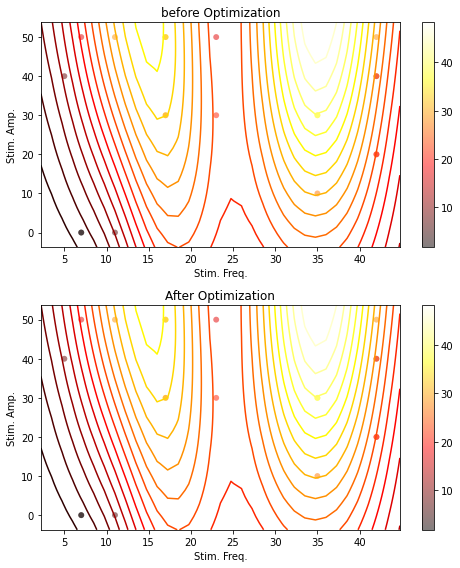

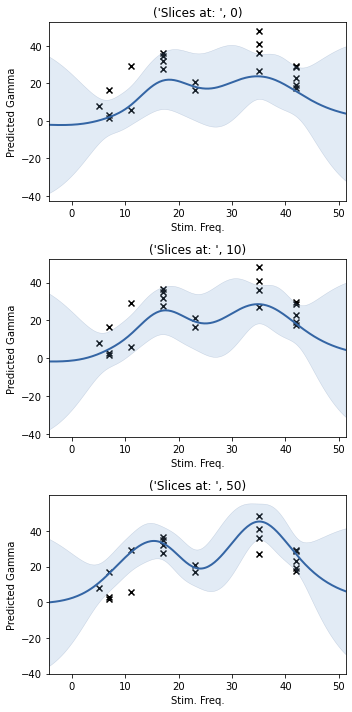

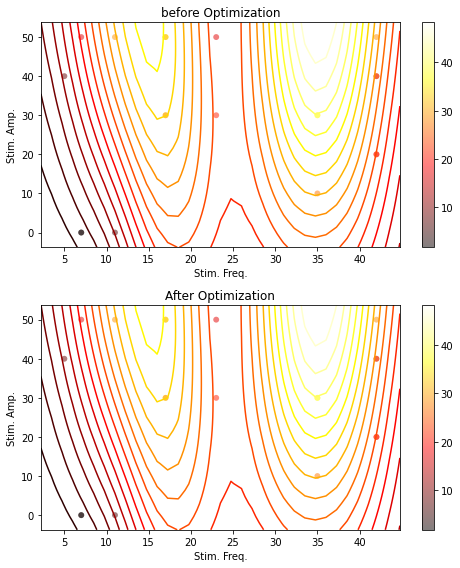

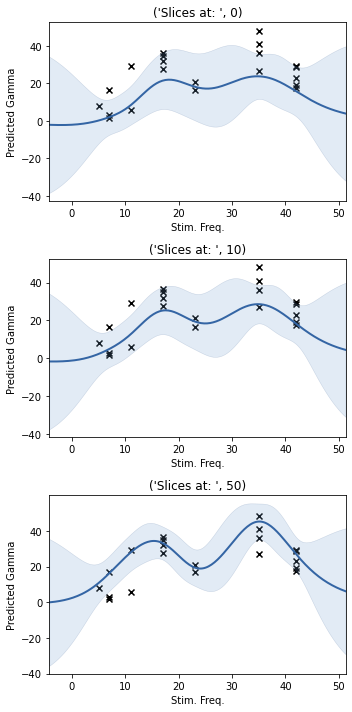

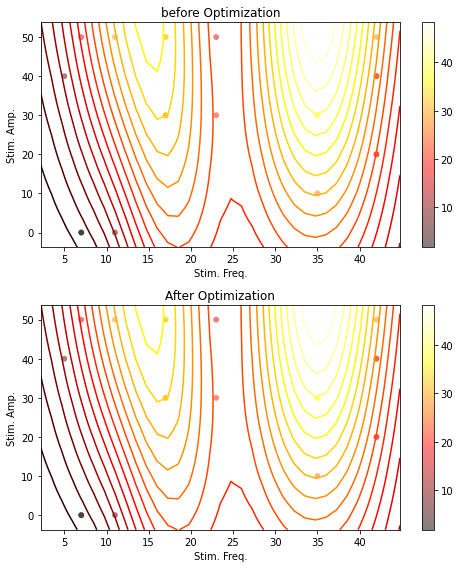

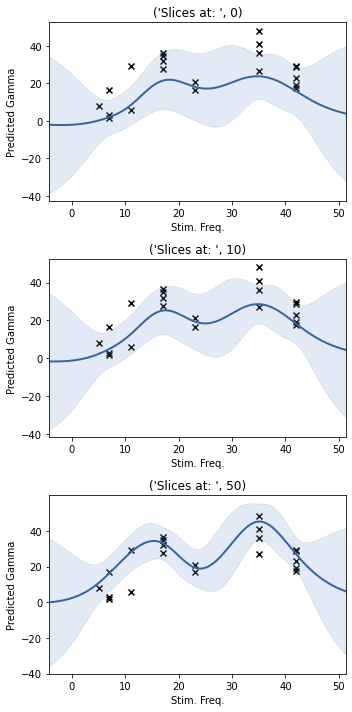

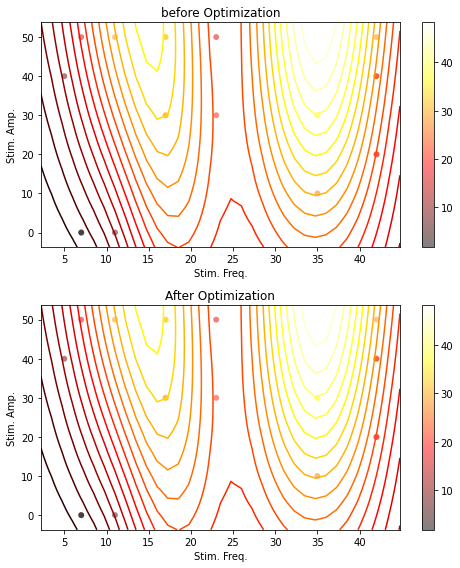

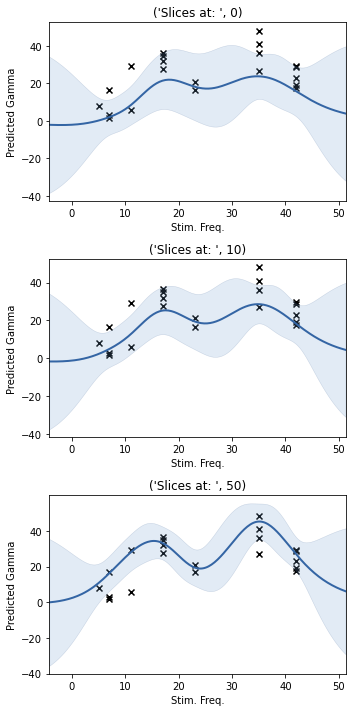

In [22]:
# TODO: set up a loop to optimize at every acquistion for 10 total times, then plot before and after.
ucb = np.empty((n_acquisition, n_samples))
freq_choices = [5,7,11,17, 23, 35, 42]
nu = 0.1
print("nu set at: ", nu)

for a in range(1, n_acquisition):
    state_est_BaO = np.empty((2, n_samples))
    simY_BaO = np.empty((2, n_samples))
    simMse_BaO = np.empty((2, n_samples))

    for i in range(n_samples-1):
            # print(i)
        state_est_BaO[0, i:i+2], simY_BaO[0:2, i:i+2], simMse_BaO[0:2, i:i+2] = model.sample(testX_BaO, trained_model_BaO);

    print("mean is: \n",simY_BaO[:,0],"\n\n Variance is: \n", simMse_BaO[:,0])
    # posteriorTestY
    print(np.shape(state_est_BaO),'\n',state_est_BaO[:,0:10])
    print(np.shape(simY_BaO),'\n', np.shape(simMse_BaO))

    ucb[a,:]= model.acquisition_function(simY_BaO, simMse_BaO, nu, 1)[1,:]
    # print(np.shape(ucb))
    median_ucb = np.median(ucb[a, :])
    next_freq_idx = abs(median_ucb-freq_choices).argmin()

    print(median_ucb)
    print(next_freq_idx, 'next freq is: ', freq_choices[next_freq_idx])
    
    # From sample #20next_idx_to_optimize, pick 20 samples in U1, X0 and X1 such that the freq = 42
    next_idx_to_optimize = []

    for idx in range(n_samples+a, np.shape(U1)[0]):
        if U1.loc[idx,'Stim_1']==freq_choices[next_freq_idx]:
            # print(idx)
            next_idx_to_optimize.append(idx)
            if np.size(next_idx_to_optimize)>=1:
                break

    print(next_idx_to_optimize)
    
    U1_next = U1.loc[next_idx_to_optimize,:]
    X0_psd_next = X0_psd.loc[next_idx_to_optimize]
    X1_next = X1[next_idx_to_optimize,:]
    print('Sum preStim gamma are: \n', X0_psd_next, '\n','freq and amplitude used are: \n', U1_next)
    print('sum postStim gamma are: \n', X1_next, '\n', np.shape(X1_next))
    
    # Combine initial samples with next samples
    U1_combo = pd.concat([U1_init,U1_next])
    X0_psd_combo = pd.concat([X0_psd_init, X0_psd_next])
    X1_combo = np.append(X1_init, X1_next, axis=0)

    print(np.shape(X1_combo))
    print(U1_combo, '\n', X0_psd_combo.head(), '\n', X1_combo[0:4])
    
    U1_combo.reset_index()
    U1_combo=U1_combo[['Stim_1', 'Stim_2']]
    U1_combo.head()

    X0_psd_combo.reset_index()
    X0_psd_combo= X0_psd_combo[['sum_preStim_gamma']]
    X0_psd_combo.head()

    x_BaO, y_BaO, trained_model_BaO =model.initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)
    

In [23]:
ucb = np.empty((n_acquisition, n_samples))
freq_choices = [5,7,11,17, 23, 35, 42]
print(np.shape(ucb))

(10, 150)


In [25]:
for a in range(1, n_acquisition):
    ucb[a,:]= model.acquisition_function(simY_BaO, simMse_BaO, nu, 1)[1,:]
    print(np.shape(ucb))
    print(ucb)
    max_ucb = np.max(ucb[a,:]).argmax()
    print(max_ucb)
    next_freq_idx = abs(max_ucb-freq_choices).argmin()

    print(median_ucb)
    print(next_freq_idx, 'next freq is: ', freq_choices[next_freq_idx])

(10, 150)
[[1.00563735e-311 1.00564007e-311 1.00544929e-311 ... 1.00544903e-311
  1.00544931e-311 1.00544958e-311]
 [4.49119969e+001 4.49119969e+001 4.49119969e+001 ... 4.49119969e+001
  4.49119969e+001 4.49119969e+001]
 [4.49119969e+001 4.49119969e+001 4.49119969e+001 ... 4.49119969e+001
  4.49119969e+001 4.49119969e+001]
 ...
 [4.49119969e+001 4.49119969e+001 4.49119969e+001 ... 4.49119969e+001
  4.49119969e+001 4.49119969e+001]
 [4.49119969e+001 4.49119969e+001 4.49119969e+001 ... 4.49119969e+001
  4.49119969e+001 4.49119969e+001]
 [4.49119969e+001 4.49119969e+001 4.49119969e+001 ... 4.49119969e+001
  4.49119969e+001 4.49119969e+001]]
0
44.91199693720559
0 next freq is:  5
(10, 150)
[[1.00563735e-311 1.00564007e-311 1.00544929e-311 ... 1.00544903e-311
  1.00544931e-311 1.00544958e-311]
 [4.49119969e+001 4.49119969e+001 4.49119969e+001 ... 4.49119969e+001
  4.49119969e+001 4.49119969e+001]
 [4.49119969e+001 4.49119969e+001 4.49119969e+001 ... 4.49119969e+001
  4.49119969e+001 4.49119

In [22]:
ucb = np.empty((1))
freq_choices = [5,7,11,17, 23, 35, 42]

ucb= model.acquisition_function(simY_BaO, simMse_BaO, nu, 1)
print(np.shape(ucb))
median_ucb = np.median(ucb)
next_freq_idx = abs(median_ucb-freq_choices).argmin()
    
print(median_ucb)
print(next_freq_idx, 'next freq is: ', freq_choices[next_freq_idx])

(2, 150)
39.50774763017829
6 next freq is:  42
ERROR! Session/line number was not unique in database. History logging moved to new session 98


In [54]:
np.shape(U1)[0]
print(U1.loc[20,'Stim_1'])

11


In [55]:
# From sample #20next_idx_to_optimize, pick 20 samples in U1, X0 and X1 such that the freq = 42
next_idx_to_optimize = []

for idx in range(n_samples, np.shape(U1)[0]):
    if U1.loc[idx,'Stim_1']==freq_choices[next_freq_idx]:
        # print(idx)
        next_idx_to_optimize.append(idx)
        if np.size(next_idx_to_optimize)>1:
            break
        
print(next_idx_to_optimize)

[163, 164]


In [56]:
U1_next = U1.loc[next_idx_to_optimize,:]
X0_psd_next = X0_psd.loc[next_idx_to_optimize]
X1_next = X1[next_idx_to_optimize,:]
print('Sum preStim gamma are: \n', X0_psd_next, '\n','freq and amplitude used are: \n', U1_next)
print('sum postStim gamma are: \n', X1_next, '\n', np.shape(X1_next))

Sum preStim gamma are: 
      sum_preStim_gamma
163           1.736952
164           0.821572 
 freq and amplitude used are: 
      Stim_1  Stim_2
163      42      40
164      42      10
sum postStim gamma are: 
 [[17.37915242]
 [ 7.48766022]] 
 (2, 1)


#### Plot before and after optimization 

In [57]:
# Combine initial samples with next samples
U1_combo = pd.concat([U1_init,U1_next])
X0_psd_combo = pd.concat([X0_psd_init, X0_psd_next])
X1_combo = np.append(X1_init, X1_next, axis=0)

print(np.shape(X1_combo))
print(U1_combo, '\n', X0_psd_combo.head(), '\n', X1_combo[0:4])

(22, 1)
     Stim_1  Stim_2
0        17      30
1        42      40
2        35      30
3        23      50
4        42      50
5        35      50
6        11       0
7         7       0
8        17      30
9        11      50
10       17      50
11       35      30
12        5      40
13       42      20
14       23      30
15        7      50
16       35      10
17       17      50
18        7       0
19       42      20
163      42      40
164      42      10 
    sum_preStim_gamma
0           3.266571
1           2.425945
2           3.117866
3           2.868627
4           3.521665 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010369]]


In [58]:
U1_combo.reset_index()
U1_combo=U1_combo[['Stim_1', 'Stim_2']]
U1_combo.head()

X0_psd_combo.reset_index()
X0_psd_combo= X0_psd_combo[['sum_preStim_gamma']]
X0_psd_combo.head()


,sum_preStim_gamma
0,3.266571
1,2.425945
2,3.117866
3,2.868627
4,3.521665


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a9e5a723d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a9e5763940>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0005   7.962524e+01   3.496965e-02 
    00s05  0008   7.935234e+01   6.689312e-05 
    00s07  0010   7.935193e+01   4.166894e-05 
    00s19  0025   7.935079e+01   7.182260e-06 
    00s22  0030   7.935058e+01   1.939578e-10 
Runtime:     00s22
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x2a9e544f730>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a9e5b013d0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a9e5a01e50>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2a9e5c292e0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2a9e5c29310>]}

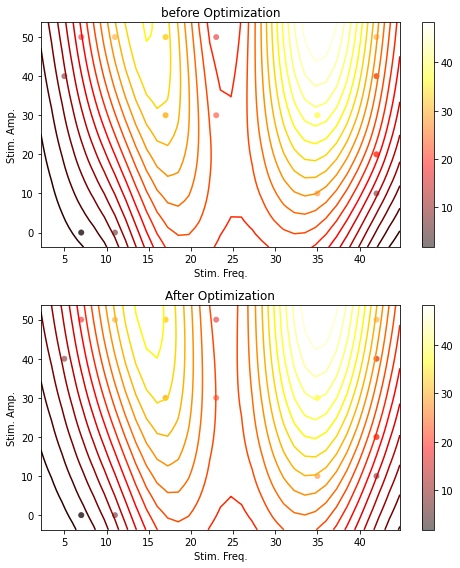

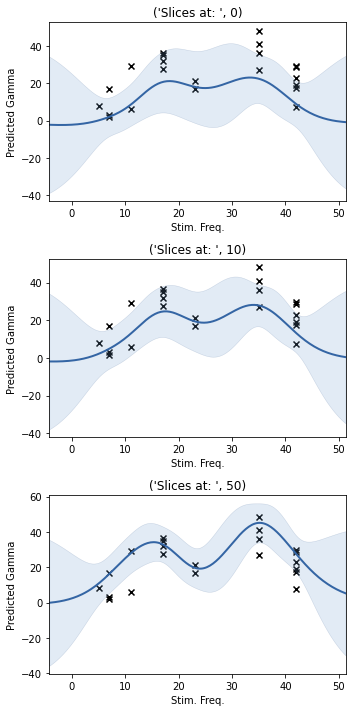

In [59]:
x_BaO, y_BaO, trained_model_BaO =model.initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

In [18]:
x_BaO, y_BaO, trained_model_BaO = model.bayes_opt_update_state(trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, 
                                                               ker_BaO, slice_dim, ylabel, initialize_data_dr_sim)

# initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

NameError: name 'sample' is not defined

### Acquisition Function draft
function [X_samples, Y_samples, X_optimal_est, Y_optimal_est, Y_ground_truth] =  ...
    bayes_opt_on_state_dr_model(objective_model, input_space, n_samples, n_burn_in, acquisition_function, acq_params, measurement_function)


X_samples       = nan(n_samples, size(input_space,2));
X_optimal_est   = nan(n_samples, size(input_space,2));

Y_samples       = nan(n_samples, 1);
Y_optimal_est   = nan(n_samples, 1);
Y_ground_truth  = nan(n_samples, 1);

objective_est   = gp_object(); % GP model used in BaO 
burn_in_idx     = randi(size(input_space,1), n_burn_in,1);

objective_model.set_initial_state(); % Ground Truth simulation model 

for c1 = 1:n_samples
    
    if c1 <= n_burn_in
        X_samples(c1,:)     = input_space(burn_in_idx(c1),:);
    else
        X_samples(c1,:)     = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, c1);
    end
    
    Y_samples(c1,1)         = objective_model.sample(X_samples(c1,:));
    
    if c1 > 1    
        objective_est.initialize_data(X_samples(1:c1,:), Y_samples(1:c1)) % Exclude NaN when initializing GP

        [X_optimal_est(c1,:), Y_optimal_est(c1,:)] ...
            = objective_est.discrete_extrema(input_space);

        Y_ground_truth(c1)  = objective_model.predict_state(X_optimal_est(c1,:));
    end
    objective_model.transition_state();
end

end


#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end

##### the actual acquisition function is: upper_confidence_bound()

function ucb = upper_confidence_bound(Y_mean, Y_uncertainty, nu, t)

beta   	= 2 * log(t.^2*pi^2/(6));
ucb     = Y_mean + sqrt(nu*beta) * Y_uncertainty;

end

In [ ]:
nu = 0.1
# t = the sample we are on 
